In [16]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%autosave 100

Mounted at /content/drive/


Autosaving every 100 seconds


In [0]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
total=30

quizes = np.empty((total, 81), np.float32)
solutions = np.empty((total, 81), np.int64)

i=0
f = open("/content/drive/My Drive/Colab Notebooks/sudoku_test.csv")
for line in f:
    quiz, solution = line.strip().split(",")
    quizes[i] = [int(i) for i in quiz]
    solutions[i] = [int(i) for i in solution]
    i += 1

quizes = quizes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

print("quizes\n", quizes[0])
print("solutions\n", solutions[0])

quizes
 [[0. 8. 0. 0. 3. 2. 0. 0. 1.]
 [7. 0. 3. 0. 8. 0. 0. 0. 2.]
 [5. 0. 0. 0. 0. 7. 0. 3. 0.]
 [0. 5. 0. 0. 0. 1. 9. 7. 0.]
 [6. 0. 0. 7. 0. 9. 0. 0. 8.]
 [0. 4. 7. 2. 0. 0. 0. 5. 0.]
 [0. 2. 0. 6. 0. 0. 0. 0. 9.]
 [8. 0. 0. 0. 9. 0. 3. 0. 5.]
 [3. 0. 0. 8. 2. 0. 0. 1. 0.]]
solutions
 [[4 8 9 5 3 2 7 6 1]
 [7 1 3 4 8 6 5 9 2]
 [5 6 2 9 1 7 8 3 4]
 [2 5 8 3 4 1 9 7 6]
 [6 3 1 7 5 9 2 4 8]
 [9 4 7 2 6 8 1 5 3]
 [1 2 5 6 7 3 4 8 9]
 [8 7 6 1 9 4 3 2 5]
 [3 9 4 8 2 5 6 1 7]]


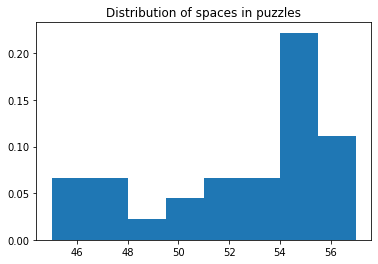

In [5]:
num_zeros = np.empty((total), np.float32)
zeros_ = np.zeros_like(quizes[0])
for i in range(quizes.shape[0]):
    num_zeros[i] = np.sum(np.equal(zeros_, quizes[i]))

plt.hist(num_zeros, bins = 8, density=True)
plt.title("Distribution of spaces in puzzles")
plt.show()

In [0]:
class ConvNet(nn.Module):
  def __init__(self, c_in, c_out, filt=3, stride=1, padding=1):
    super(ConvNet, self).__init__()

    self.conv = nn.Conv2d(c_in, c_out, (filt, filt), stride=stride, padding=padding)
    self.bn = nn.BatchNorm2d(c_out)
  
  def forward(self, x):
    n, c, h, w = x.shape
    z = F.relu(self.bn(self.conv(x)))
    return z

# n1 - number of conv layers with kernel size (3, 3) - try to learn local
# n2 - number of conv layers with kernel size (9, 9) - try to learn global
# c_mid - number of kernels in conv layers
class SudokuNet(nn.Module):
  # !!! c_out should be 10 !!!
  def __init__(self, n, n2, c_mid, c_in=1, c_out=10):
    super(SudokuNet, self).__init__()
    self.conv1 = ConvNet(c_in, c_mid)

    self.seq = nn.Sequential()
    for i in range(n):
      self.seq.add_module(str(i), ConvNet(c_mid, c_mid, 3, 1, 1))

    self.seq2 = nn.Sequential()
    for i in range(n2):
      self.seq2.add_module(str(i), ConvNet(c_mid, c_mid, 9, 1, 4))


    self.convLast = nn.Conv2d(c_mid, c_out, (3,3), stride=1, padding=1)
    self.logsoftmax = nn.LogSoftmax(dim=1)

    
  def forward(self, x):
    z = self.conv1(x)
    z = self.seq(z)
    z = self.seq2(z)
    z = self.logsoftmax(self.convLast(z))
    return z


In [0]:
# get accuracy in range [start, end) with batch_size
# change start/end to reduce running time
# choose wisely, so that |train| : |test| = 9 : 1 (or 99 : 1)
def get_accuracy(model, batch_size, start, end):
    model.train(mode=False)

    total_samples = 0
    total_correct = 0
    known_samples = 0
    known_correct = 0
    
    zeros_count = 0

    for i in range(start, end, batch_size):
        x = quizes[i:i+batch_size]
        y = solutions[i:i+batch_size]
        x = x[:, np.newaxis]

        X, y = torch.from_numpy(x), torch.from_numpy(y)
        zeros_ = torch.zeros_like(y)

        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
            x_ = torch.from_numpy(quizes[i:i+batch_size]).cuda()
            zeros_ = zeros_.cuda()


        y_ = model(X)
        _, y_ = torch.max(y_, axis=1)
        
        total_samples += 81 * batch_size
        sum_ = torch.sum(torch.eq(y_, y).type(torch.FloatTensor))
        total_correct += sum_.item()
        
        known_samp_ = 81 * batch_size - np.sum(num_zeros[i:i+batch_size])
        known_samples += known_samp_
        known_sum_ = torch.sum(torch.eq(y_, x_).type(torch.FloatTensor))
        known_correct += known_sum_.item()

        zeros_count += torch.sum(torch.eq(y_, zeros_).type(torch.FloatTensor)).item()

        print(f'batch: {i}, total_correct: [{int(sum_.item())}/{81*batch_size}], known_correct: [{int(known_sum_.item())}/{int(known_samp_)}], unknown_correct: [{int(sum_.item()) - int(known_sum_.item())}/{int(81*batch_size - known_samp_)}], zeros in answer: {int(zeros_count)}')

    return total_correct / total_samples, known_correct / known_samples, (total_correct - known_correct) / (total_samples - known_samples), zeros_count

In [13]:
n = 10
n2 = 0
c_mid=100
model = SudokuNet(n=n, n2=n2, c_mid=c_mid)
if torch.cuda.is_available():
    print("cuda")
    model.cuda()
else:
    print("cpu")

cuda


In [14]:
# load model from Sudoku_train.ipynb
checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/model_" + str(n) + "_" + str(n2) + "_" + str(c_mid) + ".tar")
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [15]:
total_accuracies, known_accuracies, unknown_accuracies, zeros_count = get_accuracy(model, 1, 0, total)
print(f"Total accuracy: {total_accuracies} on {total} tests")
print(f"Known accuracy: {known_accuracies} on {total} tests")
print(f"Unknown accuracy: {unknown_accuracies} on {total} tests")
print(f"Zeros count: {zeros_count} on {total} tests")

batch: 0, total_correct: [78/81], known_correct: [34/34], unknown_correct: [44/47], zeros in answer: 0
batch: 1, total_correct: [77/81], known_correct: [36/36], unknown_correct: [41/45], zeros in answer: 0
batch: 2, total_correct: [77/81], known_correct: [34/34], unknown_correct: [43/47], zeros in answer: 0
batch: 3, total_correct: [72/81], known_correct: [36/36], unknown_correct: [36/45], zeros in answer: 0
batch: 4, total_correct: [70/81], known_correct: [34/34], unknown_correct: [36/47], zeros in answer: 0
batch: 5, total_correct: [76/81], known_correct: [35/35], unknown_correct: [41/46], zeros in answer: 0
batch: 6, total_correct: [54/81], known_correct: [28/28], unknown_correct: [26/53], zeros in answer: 0
batch: 7, total_correct: [60/81], known_correct: [26/26], unknown_correct: [34/55], zeros in answer: 0
batch: 8, total_correct: [57/81], known_correct: [26/26], unknown_correct: [31/55], zeros in answer: 0
batch: 9, total_correct: [60/81], known_correct: [28/28], unknown_correct